In [144]:
import scipy
from scipy.stats import median_abs_deviation as mad
import numpy as np
from matplotlib import pyplot as plt
import time
from  scipy.io import loadmat as loadmat

In [145]:
# to suppress matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

In [146]:
rootfolder = '..'

Useful function for the plot

In [147]:
def display_band( X, par,epsi=0.001,col='k'):
    x1 = np.min(X[0, :])
    x2 = np.max(X[0, :])
    y1 = np.min(X[1, :])
    y2 = np.max(X[1, :])

    # extend the line for the k# of its lenght 
    k = 0.01
    dx = x2-x1
    dy = y2-y1
    l = np.sqrt(dx**2+dy**2)
    x1 = x1 - k*l
    x2 = x2 + k*l
    y1 = y1 - k*l
    y2 = y2 + k*l
    ##
    if np.abs(par[1])<2e-2 :
        #disp('vertical line')
        a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
        b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
    else:
        a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
        b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

    if np.abs(par[0])<1e-5:
        v = np.array([0,1]) 
    else:    
        v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

    v = v / np.sqrt(np.sum(v**2))
    # corners of the bands
    v = v[:, np.newaxis]
    a1 = a - epsi * v
    a2 = a + epsi * v
    b1 = b - epsi * v
    b2 = b + epsi * v

    px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
    py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
    plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
    plt.gca().set_aspect('equal')

def display_clust(X, G, cmap):
    G = np.asarray(G, dtype=int)
    switch_out = 1
    smb = 'o'
    col = []
    num_clust = int(np.max(G))

    for i in range(1, num_clust+1):
        id = G == i
        id = id.squeeze()
        x = X[0, id]
        y = X[1, id]
        if len(col) == 0:
            plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
        else:
            plt.scatter(x,y,50,col,marker=smb,edgecolors=col, alpha=0.1)
        if switch_out == 1:
            id = G == 0
            id = id.squeeze()
            plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)

Function that computes the residual between points and a line

In [148]:
def res_line(X, M):
  if len(M.shape) > 1:
    num_lines = M.shape[1]
  else:
    num_lines = 1

  if num_lines == 1:
    d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
  else:
    n = X.shape[1]
    d = np.zeros((n, num_lines))
    for i in range(num_lines):
      d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])
  return d

Functions to add outlier to the dataset

In [149]:
def addOutliersInBB(X, nOutliers, k=0.1):
    xmin = np.min(X[0, :])
    xmax = np.max(X[0, :])
    ymin = np.min(X[1, :])
    ymax = np.max(X[1, :])
    wx = xmax-xmin
    wy = ymax -ymin
    dx = k*wx
    dy = k*wy

    Y = np.hstack((X,np.vstack((xmax-xmin+2*dx * np.random.uniform(size=(1, nOutliers)) + xmin-dx, 
                             ymax-ymin+2*dy * np.random.uniform(size=(1, nOutliers)) + ymin-dy))
                ))
    return Y



Ransac
------
Use the implementation from the last lecture

In [150]:
def fit_line_dlt(P):
  
  mean_X = np.mean(P.T[:, 0])
  std_X = np.std(P.T[:, 0])
  
  mean_Y = np.mean(P.T[:, 1])
  std_Y = np.std(P.T[:, 1])
  
  X_normalized = (P.T[:, 0] - mean_X) / std_X
  Y_normalized = (P.T[:, 1] - mean_Y) / std_Y
  
  # design matrix
  A = np.hstack([X_normalized[:, np.newaxis], Y_normalized[:, np.newaxis], np.ones_like(X_normalized)[:, np.newaxis]])
  
  # SVD
  _,_, Vt = np.linalg.svd(A)
  
  theta = Vt[-1, :]
  
  theta[0]/=std_X
  theta[1]/=std_Y
  theta[2] -= (theta[0] * mean_X + theta[1] * mean_Y)
  
  theta /= (theta[0]**2 + theta[1]**2)**0.5
  
  residuals = res_line(P, theta) 
  residual_error = np.sum(residuals ** 2)
  
  return theta, residuals, residual_error


In [151]:
def simpleRANSAC(X, eps, cardmss = 2):
  """
  SIMPLERANSAC - Robust fit with the LMEDS algorithm
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1] 
  # Desired probability of success
  alpha = 0.99

  # Pessimistic estimate of inliers fraction
  f = 0.5 
  
  # set maximum number of iterations
  # use the reverse formula from probability 1-(1-(1-e)^s)^n = alpha
  MaxIterations = (np.log(1-alpha))/(np.log(1-(1-f)**cardmss))

  # set maximum consensus reached
  maxscore = -np.inf
 
  for i in range(int(MaxIterations)):
      
    # Generate cardmss random indices in the range 0..n-1
    mss_idx = np.random.choice(n, cardmss, replace=False)
    mss = X[:, mss_idx]
    
    # Fit model to this minimal sample set.
    theta,_,_ = fit_line_dlt(mss)

    # Evaluate distances between points and model
    sqres = res_line(X, theta)

    # identify inliers: consensus set
    inliers = np.where(sqres < eps)[0]

    # assess consensus (the number of inliers)
    score = len(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta

  return bestmodel, bestinliers

Sequential Ransac
-----------------
Prepare the dataset and set the parameters


In [152]:
epsi = 0.02 # inlier threshold for ransac
stars = True

temp = loadmat(f'{rootfolder}/data/star5.mat') if stars  else loadmat(f'{rootfolder}/data/stair4.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 3          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers 
G = np.vstack((G, np.zeros((nOut, 1))))


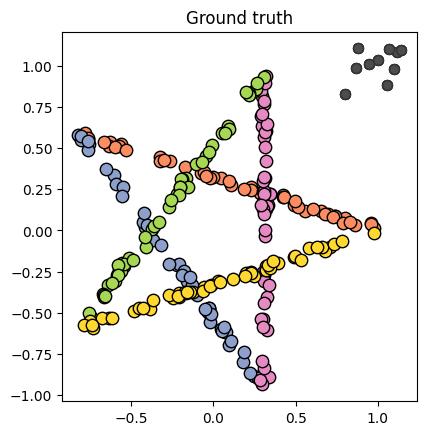

In [153]:
plt.figure(1)
display_clust(X,G, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

Implement the sequential ransac algorithm

In [154]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    model, bestinliers = simpleRANSAC(Y, epsi, cardmss)
    
    if len(bestinliers) < E_min:
      break
    
    currentModel.append(model)
    currentInliers.append(bestinliers)

    # remove current inliers
    Y = np.delete(Y, bestinliers, axis=1)
    cnt += 1
    

# TODO: implement another stopping criteria based on the consensus of the last model found


Show the iteration of Sequential Ransac

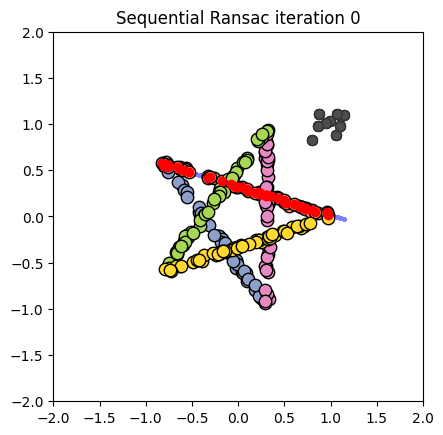

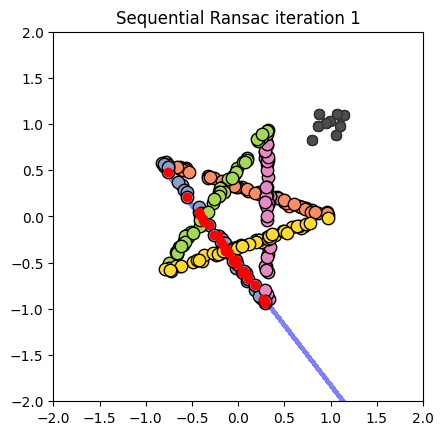

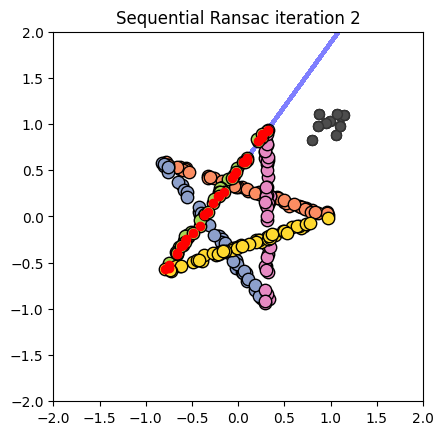

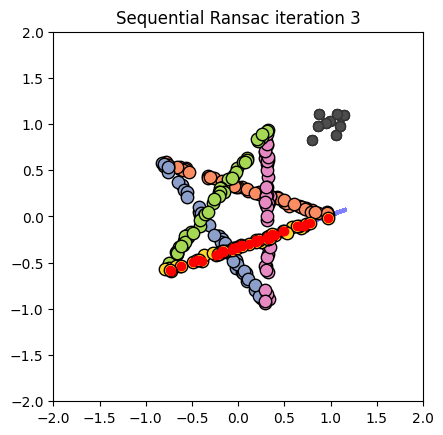

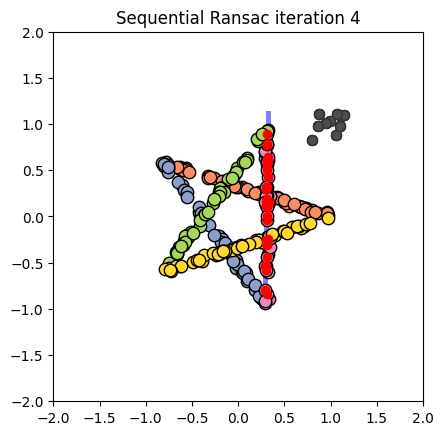

In [155]:
Y = X.copy()
plt.gca().set_aspect('equal')
if len(currentModel) < kappa:
  print("----------------- Not all models were found! -----------------")
  
for i in range(len(currentModel)):
    # display a band for each model estimated (see display_band function)
    display_band(Y, currentModel[i], epsi, col)
    
    # plot inliers for this model
    display_clust(X,G, cmap)
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], color = 'r')
   
    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)

    if stars: #plot shenanigans
      plt.xlim([-2,2])
      plt.ylim([-2,2])
    plt.title(f'Sequential Ransac iteration {i:d}')
    plt.show()

TODO: MultiModel fitting on circle
----------------------------
Implement Ransac (thus run Sequential Ransac) to fit circles

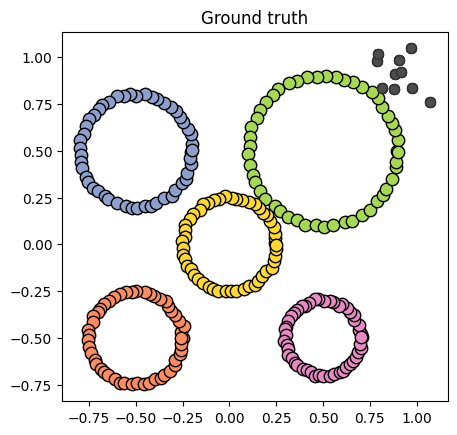

In [156]:
epsi = 0.02 # inlier threshold for ransac
temp = loadmat(f'{rootfolder}/data/circle5.mat') 

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 3          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers 
G = np.vstack((G, np.zeros((nOut, 1))))

plt.figure(1)
display_clust(X,G, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

In [157]:
# equation of circle centered at (x_c,y_c) with radius r
# (x-x_c)^2 + (y-y_c)^2 = r^2
# x^2 - 2*x_c*x + x_c^2 + y^2 - 2*y_c*y + y_c^2 = r^2

# x^2 + y^2 = (2x_c)x + (2y_c)y + (r^2 - x_c^2 - y_c^2)
# solve the least squares problem to find the parameters of the circle

def fit_circle(P):
  
  X = P[0, :]
  Y = P[1, :]
  
  A = np.vstack([X, Y, np.ones_like(X)])
  B = X**2 + Y**2
  
  theta = np.linalg.lstsq(A.T, B, rcond=None)[0].flatten()
  
  xc = theta[0] / 2
  yc = theta[1] / 2
  r = np.sqrt(theta[2] + xc**2 + yc**2)
  
  return np.array([xc, yc, r])

def res_circle(P, M):
  x = P[0, :]
  y = P[1, :]
  return np.abs((x - M[0])**2 + (y - M[1])**2 - M[2]**2)

def simpleRANSAC(X, eps, cardmss = 2):
  """
  SIMPLERANSAC - Robust fit with the LMEDS algorithm
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1] 
  # Desired probability of success
  alpha = 0.99

  # Pessimistic estimate of inliers fraction
  f = 0.6

  # set maximum number of iterations
  # use the reverse formula from probability 1-(1-(1-e)^s)^n = alpha
  MaxIterations = (np.log(1-alpha))/(np.log(1-(1-f)**cardmss))

  # set maximum consensus reached
  maxscore = -np.inf
 
  for i in range(int(MaxIterations)):
      
    # Generate cardmss random indices in the range 0..n-1
    mss_idx = np.random.choice(n, cardmss, replace=False)
    mss = X[:, mss_idx]
    
    # Fit model to this minimal sample set.
    theta = fit_circle(mss)

    # Evaluate distances between points and model
    sqres = res_circle(X, theta)

    # identify inliers: consensus set
    inliers = np.where(sqres < eps)[0]

    # assess consensus (the number of inliers)
    score = len(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta

  return bestmodel, bestinliers
  

In [158]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    model, bestinliers = simpleRANSAC(Y, epsi, cardmss)
    
    if len(bestinliers) < E_min:
      break
    
    currentModel.append(model)
    currentInliers.append(bestinliers)

    # remove current inliers
    Y = np.delete(Y, bestinliers, axis=1)
    cnt += 1
    

# TODO: implement another stopping criteria based on the consensus of the last model found


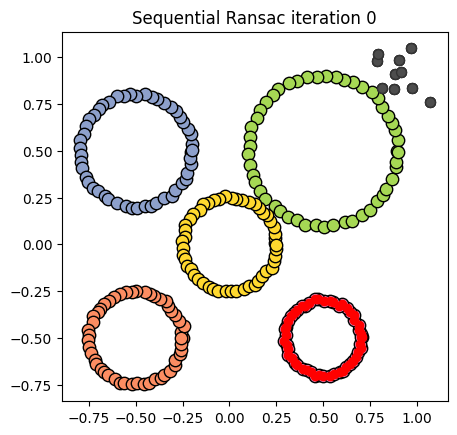

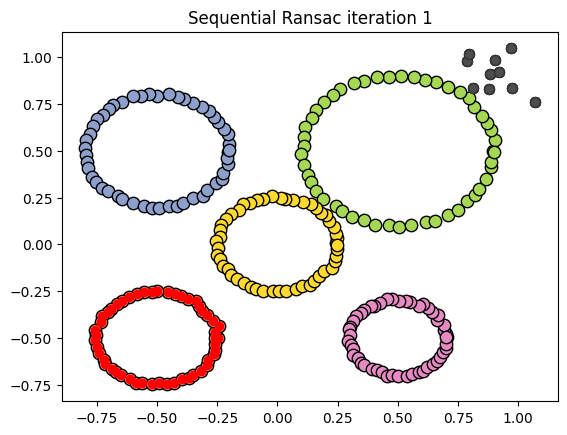

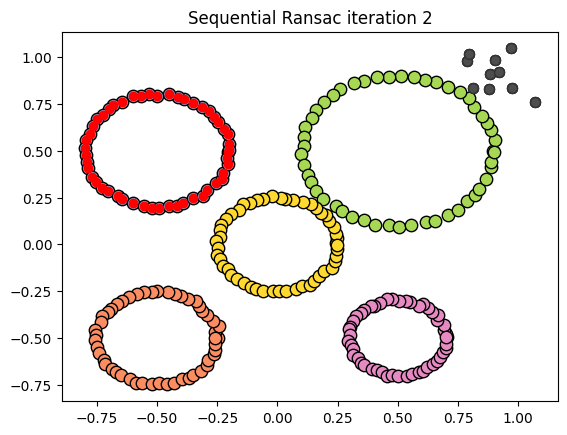

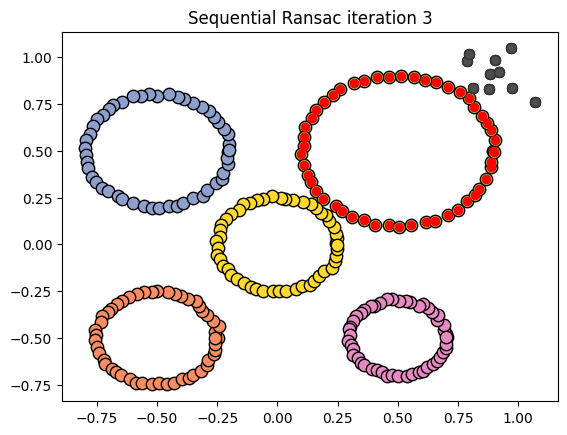

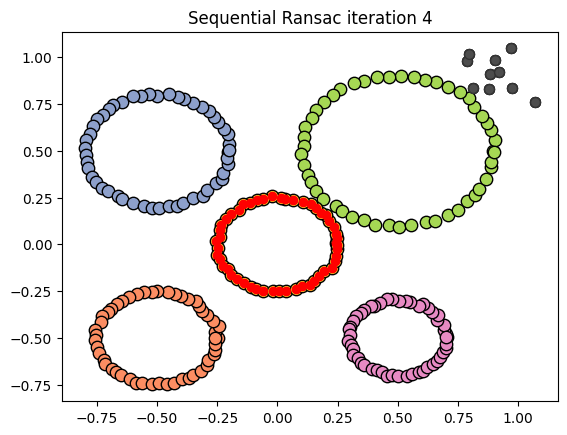

In [159]:
Y = X.copy()
plt.gca().set_aspect('equal')
if len(currentModel) < kappa:
  print("----------------- Not all models were found! -----------------")
  
for i in range(len(currentModel)):
    
    # plot inliers for this model
    display_clust(X,G, cmap)
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], color = 'r')
   
    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)
    plt.title(f'Sequential Ransac iteration {i:d}')
    plt.show()